En esta notebook:



*   ETM para LDA
*  vMF para LDA


# ETM para LDA

VAMOS a:

implementar un modelo ETM (Embedded Topic Model) usando LDA en cada texto de la columna text del DataFrame df_newsgroups y guardar el resultado como una nueva columna, sigue estos pasos:



Preparar el ETM: Usa un modelo ETM con los embeddings obtenidos de Doc2Vec. Un ETM normalmente necesita representaciones de los textos en un espacio de baja dimensionalidad y una lista de palabras para modelar los temas. Usamos los topicos originales para modelar los temas

Implementar el ETM: usamos una librería como PyTorch para crear y entrenar el ETM. Define una arquitectura que tome los embeddings de LDA como entrada y genere los temas.

Guardar el Output: Luego de entrenar el ETM, aplicamos el modelo a cada documento para generar su asignación de tema. Guarda este output en una nueva columna, por ejemplo, etm_topic.

Calculamos el porcentaje de documentos por tópico que fueron asignados correctamente, las correpondientes matrices de confusión y la coherencia c_v.

In [ ]:
!pip install torch torchvision
!pip install octis
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 23.6 MB/s eta 0:00:00
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp310-cp310-linux_x86_64.whl size=251407 sha256=0afcc27951dd085f8fcd6416e9090da5bbdeeb937cc470a928ba248836f39aad
  Stored in directory: /root/.cache/pip/wheels/79/c7/19/a8c85928f8e629654b8e1adb3c8091f0bb77344d0ee9954a85
Successfully built libsvm
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-

In [ ]:
!pip install -q torch torchvision octis gensim

VAMOS a hacer:

implementar un modelo ETM (Embedded Topic Model) usando Doc2Vec en cada texto de la columna text del DataFrame df_newsgroups y guardar el resultado como una nueva columna, sigue estos pasos:

Entrenar Doc2Vec: Primero, entrena un modelo Doc2Vec con los textos en df_newsgroups para obtener los embeddings de los documentos.

Preparar el ETM: Usa un modelo ETM con los embeddings obtenidos de Doc2Vec. Un ETM normalmente necesita representaciones de los textos en un espacio de baja dimensionalidad y una lista de palabras para modelar los temas. Usamos los topicos originales para modelar los temas

Implementar el ETM: Puedes usar una librería como PyTorch para crear y entrenar el ETM. Define una arquitectura que tome los embeddings de Doc2Vec como entrada y genere los temas.

Guardar el Output: Luego de entrenar el ETM, puedes aplicar el modelo a cada documento para generar su asignación de tema. Guarda este output en una nueva columna, por ejemplo, etm_topic.

In [ ]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups

# Descargar el conjunto de datos 20 Newsgroups
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Crear un DataFrame a partir de los datos de newsgroups, incluyendo las etiquetas y los nombres de los tópicos
df_newsgroups = pd.DataFrame({
    'text': newsgroups_data.data,  # Los textos de los documentos
    'label': newsgroups_data.target,  # Las etiquetas de los documentos
    'topic': [newsgroups_data.target_names[label] for label in newsgroups_data.target]  # Los nombres de los tópicos
})

# Guardar el DataFrame en un archivo CSV
df_newsgroups.to_csv('20newsgroups_data_with_topics.csv', index=False)

# Mostrar el DataFrame creado
df_newsgroups.head()  # Mostrar las primeras filas del DataFrame


,text,label,topic
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware


In [ ]:
import pandas as pd
import gensim
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# Preprocesar el texto y tokenizar cada documento
df_newsgroups['tokens'] = df_newsgroups['text'].apply(lambda x: gensim.utils.simple_preprocess(x))

# Crear un diccionario y un corpus
dictionary = Dictionary(df_newsgroups['tokens'])
corpus = [dictionary.doc2bow(text) for text in df_newsgroups['tokens']]

# Entrenar el modelo LDA
num_topics = 20  # Configura el número de tópicos a 20
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)

# Obtener distribuciones de tópicos de longitud constante para cada documento
lda_embeddings = []
for bow in corpus:
    # Generar el vector de tópicos con 20 probabilidades usando `minimum_probability=0`
    topic_distribution = lda_model.get_document_topics(bow, minimum_probability=0)
    embedding = [prob for _, prob in sorted(topic_distribution, key=lambda x: x[0])]  # Asegura un orden consistente
    lda_embeddings.append(embedding)

# Agregar los embeddings LDA al DataFrame
df_newsgroups['lda_vector'] = lda_embeddings

# Mostrar los primeros resultados
print(df_newsgroups[['text', 'lda_vector']].head())




                                                text  \
0  \n\nI am sure some bashers of Pens fans are pr...   
1  My brother is in the market for a high-perform...   
2  \n\n\n\n\tFinally you said what you dream abou...   
3  \nThink!\n\nIt's the SCSI card doing the DMA t...   
4  1)    I have an old Jasmine drive which I cann...   

                                          lda_vector  
0  [0.03197364, 0.00038871687, 0.019130098, 0.000...  
1  [0.0010215573, 0.0010215573, 0.0010215573, 0.0...  
2  [0.2662137, 0.04104691, 0.00022768266, 0.00022...  
3  [0.0003639196, 0.032146066, 0.0003639196, 0.00...  
4  [0.00049780903, 0.00049780903, 0.00049780903, ...  


In [ ]:
df_newsgroups[:10
  ]

,text,label,topic,tokens,lda_vector
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,"[am, sure, some, bashers, of, pens, fans, are,...","[0.03197364, 0.00038871687, 0.019130098, 0.000..."
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,"[my, brother, is, in, the, market, for, high, ...","[0.0010215573, 0.0010215573, 0.0010215573, 0.0..."
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,"[finally, you, said, what, you, dream, about, ...","[0.2662137, 0.04104691, 0.00022768266, 0.00022..."
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,"[think, it, the, scsi, card, doing, the, dma, ...","[0.0003639196, 0.032146066, 0.0003639196, 0.00..."
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,"[have, an, old, jasmine, drive, which, cannot,...","[0.00049780903, 0.00049780903, 0.00049780903, ..."
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics,"[back, in, high, school, worked, as, lab, assi...","[0.00086423755, 0.36848775, 0.00086423755, 0.0..."
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware,"[ae, is, in, dallas, try, or, tech, support, m...","[0.0021752084, 0.0021752084, 0.047965515, 0.00..."
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey,"[stuff, deleted, ok, here, the, solution, to, ...","[0.00036905703, 0.00036905703, 0.00036905703, ..."
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey,"[yeah, it, the, second, one, and, believe, tha...","[0.00085111737, 0.042902008, 0.020851502, 0.00..."
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,"[if, christian, means, someone, who, believes,...","[0.11815775, 0.0007702859, 0.0007702859, 0.000..."


In [ ]:
# Imprime la longitud de cada vector en `lda_vector` para confirmar
for idx, vec in enumerate(df_newsgroups['lda_vector']):
    print(f"Document {idx} vector length: {len(vec)}")


Se han truncado las últimas 5000 líneas del flujo de salida.
Document 13846 vector length: 20
Document 13847 vector length: 20
Document 13848 vector length: 20
Document 13849 vector length: 20
Document 13850 vector length: 20
Document 13851 vector length: 20
Document 13852 vector length: 20
Document 13853 vector length: 20
Document 13854 vector length: 20
Document 13855 vector length: 20
Document 13856 vector length: 20
Document 13857 vector length: 20
Document 13858 vector length: 20
Document 13859 vector length: 20
Document 13860 vector length: 20
Document 13861 vector length: 20
Document 13862 vector length: 20
Document 13863 vector length: 20
Document 13864 vector length: 20
Document 13865 vector length: 20
Document 13866 vector length: 20
Document 13867 vector length: 20
Document 13868 vector length: 20
Document 13869 vector length: 20
Document 13870 vector length: 20
Document 13871 vector length: 20
Document 13872 vector length: 20
Document 13873 vector length: 20
Document 13874 

In [ ]:
import torch
from sklearn.preprocessing import LabelEncoder

# Paso 3: Implementar el ETM usando PyTorch
# Definir el modelo ETM basado en los embeddings de LDA y tópicos
class ETM(torch.nn.Module):
    def __init__(self, input_dim, num_topics):
        super(ETM, self).__init__()
        self.fc = torch.nn.Linear(input_dim, num_topics)

    def forward(self, x):
        return torch.nn.functional.softmax(self.fc(x), dim=1)

# Configuración de los parámetros del modelo
num_topics = len(df_newsgroups['label'].unique())  # Usar la columna 'label' directamente
input_dim = 20  # Dimensión de los vectores LDA
etm_model = ETM(input_dim=input_dim, num_topics=num_topics)

# Convertir los embeddings de LDA y las etiquetas de tópicos a tensores
lda_embeddings_tensor = torch.tensor(df_newsgroups['lda_vector'].tolist(), dtype=torch.float)
topic_labels = torch.tensor(df_newsgroups['label'].values, dtype=torch.long)  # Usar 'label' en lugar de 'topic_encoded'

# Configuración del optimizador y la función de pérdida
optimizer = torch.optim.Adam(etm_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Entrenamiento básico del ETM
num_epochs = 35000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = etm_model(lda_embeddings_tensor)
    loss = criterion(outputs, topic_labels)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}")

# Paso 4: Asignar temas generados a cada documento
with torch.no_grad():
    df_newsgroups['etm_topic'] = etm_model(lda_embeddings_tensor).argmax(dim=1).numpy()

# Mostrar los primeros resultados
print(df_newsgroups[['text', 'label', 'etm_topic']].head())


Epoch [0/35000], Loss: 2.9965
Epoch [10/35000], Loss: 2.9923
Epoch [20/35000], Loss: 2.9879
Epoch [30/35000], Loss: 2.9831
Epoch [40/35000], Loss: 2.9779
Epoch [50/35000], Loss: 2.9722
Epoch [60/35000], Loss: 2.9658
Epoch [70/35000], Loss: 2.9587
Epoch [80/35000], Loss: 2.9509
Epoch [90/35000], Loss: 2.9426
Epoch [100/35000], Loss: 2.9340
Epoch [110/35000], Loss: 2.9253
Epoch [120/35000], Loss: 2.9167
Epoch [130/35000], Loss: 2.9081
Epoch [140/35000], Loss: 2.8999
Epoch [150/35000], Loss: 2.8921
Epoch [160/35000], Loss: 2.8846
Epoch [170/35000], Loss: 2.8774
Epoch [180/35000], Loss: 2.8705
Epoch [190/35000], Loss: 2.8642
Epoch [200/35000], Loss: 2.8585
Epoch [210/35000], Loss: 2.8534
Epoch [220/35000], Loss: 2.8488
Epoch [230/35000], Loss: 2.8446
Epoch [240/35000], Loss: 2.8407
Epoch [250/35000], Loss: 2.8371
Epoch [260/35000], Loss: 2.8336
Epoch [270/35000], Loss: 2.8302
Epoch [280/35000], Loss: 2.8266
Epoch [290/35000], Loss: 2.8229
Epoch [300/35000], Loss: 2.8190
Epoch [310/35000], 

In [ ]:
df_newsgroups[:10]

,text,label,topic,tokens,lda_vector,etm_topic
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,"[am, sure, some, bashers, of, pens, fans, are,...","[0.03197364, 0.00038871687, 0.019130098, 0.000...",10
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,"[my, brother, is, in, the, market, for, high, ...","[0.0010215573, 0.0010215573, 0.0010215573, 0.0...",3
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,"[finally, you, said, what, you, dream, about, ...","[0.2662137, 0.04104691, 0.00022768266, 0.00022...",17
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,"[think, it, the, scsi, card, doing, the, dma, ...","[0.0003639196, 0.032146066, 0.0003639196, 0.00...",3
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,"[have, an, old, jasmine, drive, which, cannot,...","[0.00049780903, 0.00049780903, 0.00049780903, ...",3
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics,"[back, in, high, school, worked, as, lab, assi...","[0.00086423755, 0.36848775, 0.00086423755, 0.0...",11
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware,"[ae, is, in, dallas, try, or, tech, support, m...","[0.0021752084, 0.0021752084, 0.047965515, 0.00...",5
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey,"[stuff, deleted, ok, here, the, solution, to, ...","[0.00036905703, 0.00036905703, 0.00036905703, ...",10
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey,"[yeah, it, the, second, one, and, believe, tha...","[0.00085111737, 0.042902008, 0.020851502, 0.00...",10
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,"[if, christian, means, someone, who, believes,...","[0.11815775, 0.0007702859, 0.0007702859, 0.000...",8


In [ ]:
df_newsgroups['etm_topic'].unique()

array([10,  3, 17,  2, 14,  5, 15, 11, 12, 16, 13,  8,  6,  9,  4,  1])

In [ ]:
# Crear un diccionario que mapee los valores numéricos (label) a los nombres de los tópicos
label_to_topic = dict(zip(df_newsgroups['label'], df_newsgroups['topic']))

# Usar el diccionario para reemplazar los valores en 'etm_topic' con los nombres de los tópicos
df_newsgroups['etm_topic'] = df_newsgroups['etm_topic'].map(label_to_topic)

# Verifica el cambio
print(df_newsgroups[['text', 'label', 'topic', 'etm_topic']].head())


                                                text  label  \
0  \n\nI am sure some bashers of Pens fans are pr...     10   
1  My brother is in the market for a high-perform...      3   
2  \n\n\n\n\tFinally you said what you dream abou...     17   
3  \nThink!\n\nIt's the SCSI card doing the DMA t...      3   
4  1)    I have an old Jasmine drive which I cann...      4   

                      topic                 etm_topic  
0          rec.sport.hockey          rec.sport.hockey  
1  comp.sys.ibm.pc.hardware  comp.sys.ibm.pc.hardware  
2     talk.politics.mideast     talk.politics.mideast  
3  comp.sys.ibm.pc.hardware   comp.os.ms-windows.misc  
4     comp.sys.mac.hardware  comp.sys.ibm.pc.hardware  


Calculamos c_v



In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim

# Preprocess text into tokens for coherence calculation
df_newsgroups['tokens'] = df_newsgroups['text'].apply(lambda x: gensim.utils.simple_preprocess(x))

# Group tokens by the assigned ETM topic, and flatten each group to get a single list of words per topic
topic_words = df_newsgroups.groupby('etm_topic')['tokens'].apply(lambda docs: [word for tokens in docs for word in tokens]).tolist()

# Create a Gensim dictionary from all tokens
dictionary = Dictionary(df_newsgroups['tokens'])

# Compute coherence score using c_v (you can change this to u_mass, c_uci, or c_npmi if preferred)
coherence_model = CoherenceModel(topics=topic_words, texts=df_newsgroups['tokens'].tolist(),
                                 dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"Coherence score for ETM topics: {coherence_score:.4f}")



Coherence score for ETM topics: 0.3443


In [ ]:
df_newsgroups[:10]

,text,label,topic,tfidf_vector,topic_encoded,etm_topic
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,comp.sys.mac.hardware
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",12,sci.electronics
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,comp.sys.mac.hardware
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey,"[0.2393611281147233, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10,rec.sport.hockey
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10,rec.sport.hockey
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19,talk.religion.misc


In [ ]:
# Contar coincidencias entre 'topic' y 'etm_topic'
coincidencias = (df_newsgroups['topic'] == df_newsgroups['etm_topic']).sum()

# Mostrar el número de coincidencias
print(f"El número de documentos en los que coinciden 'topic' y 'etm_topic' es: {coincidencias}")


El número de documentos en los que coinciden 'topic' y 'etm_topic' es: 8682


In [ ]:
num_filas = df_newsgroups.shape[0]
print(f"El número de filas en el DataFrame es: {num_filas}")


El número de filas en el DataFrame es: 18846


In [ ]:
num_filas = 18846
coincidencias = 8682

porcentaje_coincidencias = (coincidencias / num_filas) * 100
print(f"El porcentaje de coincidencias es: {porcentaje_coincidencias:.2f}%")


El porcentaje de coincidencias es: 46.07%


In [ ]:
import pandas as pd

# Crear una tabla de contingencia (confusión) con pandas
matriz_confusion = pd.crosstab(df_newsgroups['topic'], df_newsgroups['etm_topic'], rownames=['Actual'], colnames=['Predicted'])

# Mostrar la matriz de confusión
print(matriz_confusion)



Predicted                 comp.graphics  comp.os.ms-windows.misc  \
Actual                                                             
alt.atheism                           1                        2   
comp.graphics                       371                       48   
comp.os.ms-windows.misc              79                      194   
comp.sys.ibm.pc.hardware             34                       52   
comp.sys.mac.hardware                33                       39   
comp.windows.x                       66                       73   
misc.forsale                         29                        9   
rec.autos                             3                        1   
rec.motorcycles                       7                        2   
rec.sport.baseball                    1                        2   
rec.sport.hockey                      4                        3   
sci.crypt                            11                        8   
sci.electronics                      37         

In [ ]:
!pip install seaborn


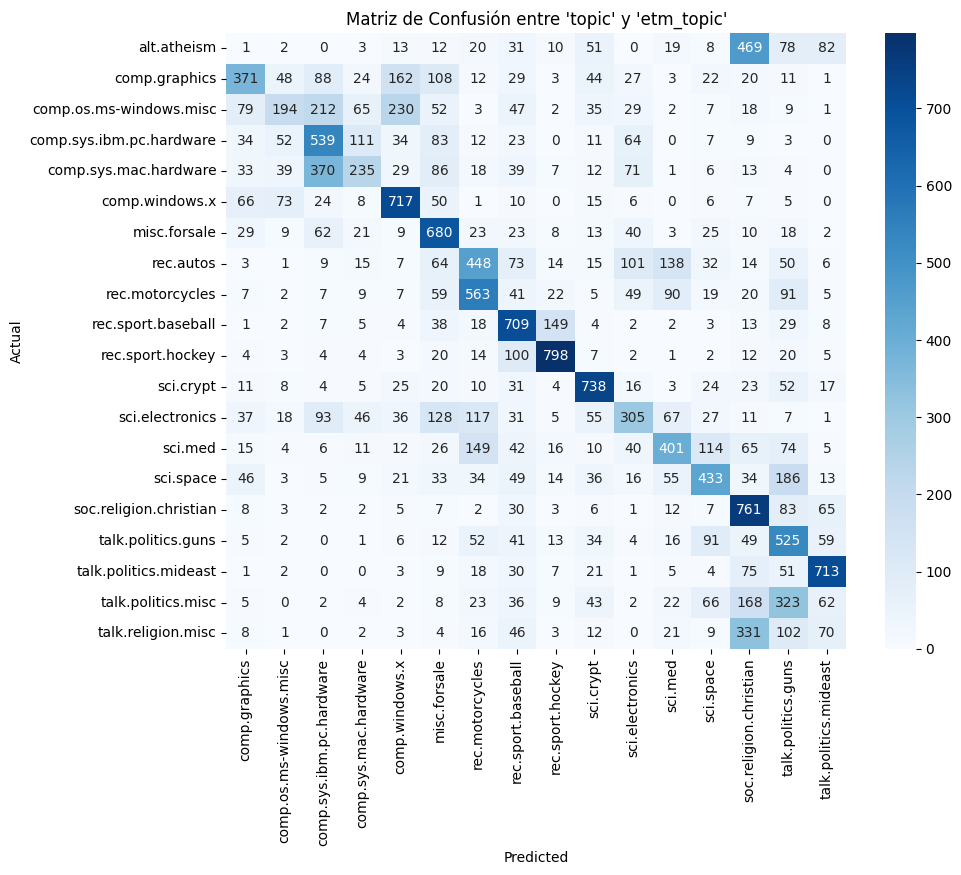

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la tabla de contingencia como matriz de confusión
matriz_confusion = pd.crosstab(df_newsgroups['topic'], df_newsgroups['etm_topic'], rownames=['Actual'], colnames=['Predicted'])

# Plotear la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Matriz de Confusión entre 'topic' y 'etm_topic'")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


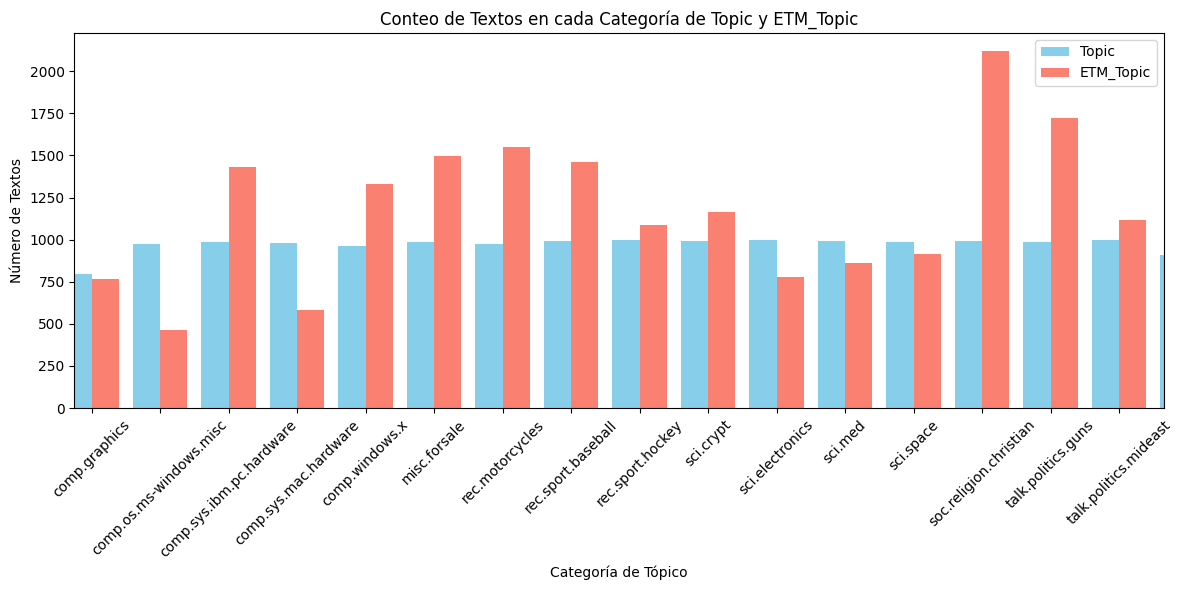

In [ ]:
import matplotlib.pyplot as plt

# Contar la cantidad de textos en cada categoría de 'topic' y 'etm_topic'
topic_counts = df_newsgroups['topic'].value_counts().sort_index()
etm_topic_counts = df_newsgroups['etm_topic'].value_counts().sort_index()

# Crear un gráfico de barras para las dos series de conteo
fig, ax = plt.subplots(figsize=(12, 6))
topic_counts.plot(kind='bar', color='skyblue', ax=ax, width=0.4, position=1, label='Topic')
etm_topic_counts.plot(kind='bar', color='salmon', ax=ax, width=0.4, position=0, label='ETM_Topic')

# Configurar etiquetas y título
plt.title("Conteo de Textos en cada Categoría de Topic y ETM_Topic")
plt.xlabel("Categoría de Tópico")
plt.ylabel("Número de Textos")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


#  vMF para LDA

VAMOS a:

implementar un modelo vMF usando LDA en cada texto de la columna text del DataFrame df_newsgroups y guardar el resultado como una nueva columna. Usamos los topicos originales para modelar los temas con vMF.

Calculamos el porcentaje de documentos por tópico que fueron asignados correctamente, matriz de confusón y la coherencia c_v.

In [ ]:
df_newsgroups[:10]

,text,label,topic,tokens,lda_vector,topic_encoded,etm_topic
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,"[am, sure, some, bashers, of, pens, fans, are,...","[0.031973902, 0.0003887168, 0.019130062, 0.000...",10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,"[my, brother, is, in, the, market, for, high, ...","[0.0010215571, 0.0010215571, 0.0010215571, 0.0...",3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,"[finally, you, said, what, you, dream, about, ...","[0.26621014, 0.04105018, 0.00022768267, 0.0002...",17,rec.sport.hockey
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,"[think, it, the, scsi, card, doing, the, dma, ...","[0.00036391962, 0.03214601, 0.00036391962, 0.0...",3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,"[have, an, old, jasmine, drive, which, cannot,...","[0.00049780903, 0.00049780903, 0.00049780903, ...",4,comp.sys.ibm.pc.hardware
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics,"[back, in, high, school, worked, as, lab, assi...","[0.00086423755, 0.3684875, 0.00086423755, 0.00...",12,sci.crypt
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware,"[ae, is, in, dallas, try, or, tech, support, m...","[0.0021752086, 0.0021752086, 0.047965623, 0.00...",4,comp.windows.x
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey,"[stuff, deleted, ok, here, the, solution, to, ...","[0.00036905706, 0.00036905706, 0.0003690571, 0...",10,rec.sport.hockey
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey,"[yeah, it, the, second, one, and, believe, tha...","[0.00085111737, 0.042901963, 0.020851528, 0.00...",10,rec.sport.hockey
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,"[if, christian, means, someone, who, believes,...","[0.11815767, 0.0007702859, 0.0007702859, 0.000...",19,rec.sport.hockey


In [ ]:
import numpy as np

df_newsgroups['lda_vector'] = df_newsgroups['lda_vector'].apply(lambda x: np.array(x, dtype=np.float32))


In [ ]:
import numpy as np
import pandas as pd
import pickle

# Definir el tamaño del bloque
block_size = 100

# Procesar en bloques y guardar cada bloque en archivos temporales
for i, start in enumerate(range(0, len(df_newsgroups), block_size)):
    end = start + block_size
    df_block = df_newsgroups.iloc[start:end].copy()

    # Normalizar embeddings en el bloque
    df_block['embedding'] = df_block['lda_vector'].apply(lambda x: x / np.linalg.norm(x) if np.linalg.norm(x) != 0 else x)

    # Guardar el bloque procesado como un archivo temporal
    with open(f'embeddings_block_{i}.pkl', 'wb') as f:
        pickle.dump(df_block[['embedding']], f)

# Para reconstruir el DataFrame final con todas las embeddings
embeddings = []
for i in range((len(df_newsgroups) + block_size - 1) // block_size):
    with open(f'embeddings_block_{i}.pkl', 'rb') as f:
        df_block = pickle.load(f)
        embeddings.extend(df_block['embedding'])

# Agregar la columna embeddings completa al DataFrame
df_newsgroups['embedding'] = embeddings
print(df_newsgroups[['lda_vector', 'embedding']].head())








                                          lda_vector  \
0  [0.03197364, 0.00038871687, 0.019130098, 0.000...   
1  [0.0010215573, 0.0010215573, 0.0010215573, 0.0...   
2  [0.2662137, 0.04104691, 0.00022768266, 0.00022...   
3  [0.0003639196, 0.032146066, 0.0003639196, 0.00...   
4  [0.00049780903, 0.00049780903, 0.00049780903, ...   

                                           embedding  
0  [0.058707114, 0.00071372685, 0.035124958, 0.00...  
1  [0.0011244748, 0.0011244748, 0.0011244748, 0.0...  
2  [0.42882273, 0.066119246, 0.0003667561, 0.0003...  
3  [0.00047719444, 0.042151958, 0.00047719444, 0....  
4  [0.0005525352, 0.0005525352, 0.0005525352, 0.0...  


In [ ]:
df_newsgroups[:10]

,text,label,topic,tokens,lda_vector,etm_topic,embedding
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,"[am, sure, some, bashers, of, pens, fans, are,...","[0.03197364, 0.00038871687, 0.019130098, 0.000...",rec.sport.hockey,"[0.058707114, 0.00071372685, 0.035124958, 0.00..."
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,"[my, brother, is, in, the, market, for, high, ...","[0.0010215573, 0.0010215573, 0.0010215573, 0.0...",comp.sys.ibm.pc.hardware,"[0.0011244748, 0.0011244748, 0.0011244748, 0.0..."
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,"[finally, you, said, what, you, dream, about, ...","[0.2662137, 0.04104691, 0.00022768266, 0.00022...",talk.politics.mideast,"[0.42882273, 0.066119246, 0.0003667561, 0.0003..."
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,"[think, it, the, scsi, card, doing, the, dma, ...","[0.0003639196, 0.032146066, 0.0003639196, 0.00...",comp.os.ms-windows.misc,"[0.00047719444, 0.042151958, 0.00047719444, 0...."
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,"[have, an, old, jasmine, drive, which, cannot,...","[0.00049780903, 0.00049780903, 0.00049780903, ...",comp.sys.ibm.pc.hardware,"[0.0005525352, 0.0005525352, 0.0005525352, 0.0..."
5,\n\nBack in high school I worked as a lab assi...,12,sci.electronics,"[back, in, high, school, worked, as, lab, assi...","[0.00086423755, 0.36848775, 0.00086423755, 0.0...",sci.space,"[0.0016405787, 0.69949883, 0.0016405787, 0.001..."
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,4,comp.sys.mac.hardware,"[ae, is, in, dallas, try, or, tech, support, m...","[0.0021752084, 0.0021752084, 0.047965515, 0.00...",comp.windows.x,"[0.0038885397, 0.0038885397, 0.08574618, 0.003..."
7,"\n[stuff deleted]\n\nOk, here's the solution t...",10,rec.sport.hockey,"[stuff, deleted, ok, here, the, solution, to, ...","[0.00036905703, 0.00036905703, 0.00036905703, ...",rec.sport.hockey,"[0.00048122148, 0.00048122148, 0.00048122148, ..."
8,"\n\n\nYeah, it's the second one. And I believ...",10,rec.sport.hockey,"[yeah, it, the, second, one, and, believe, tha...","[0.00085111737, 0.042902008, 0.020851502, 0.00...",rec.sport.hockey,"[0.00096195337, 0.04848888, 0.02356687, 0.0009..."
9,\nIf a Christian means someone who believes in...,19,talk.religion.misc,"[if, christian, means, someone, who, believes,...","[0.11815775, 0.0007702859, 0.0007702859, 0.000...",talk.politics.mideast,"[0.15977243, 0.0010415774, 0.0010415774, 0.001..."


In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer




# Paso 3: Normalizar cada embedding en una esfera y manejar normas cero
norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
norms[norms == 0] = 1  # Evitar división por cero reemplazando norma cero por uno
lda_embeddings_normalized = embeddings / norms

# Paso 4: Guardar los embeddings normalizados en el DataFrame
df_newsgroups['embedding'] = list(lda_embeddings_normalized)

# Calcular los centroides basados en los tópicos en 'topic'
unique_topics = df_newsgroups['topic'].unique()
centroides_temas = {}

for topic in unique_topics:
    # Obtener los embeddings de los documentos para el tema actual
    embeddings_tema = np.stack(df_newsgroups[df_newsgroups['topic'] == topic]['embedding'].values)

    # Calcular el centroide normalizado para el tema y manejar normas cero
    centroide = np.mean(embeddings_tema, axis=0)
    if np.linalg.norm(centroide) == 0:  # Si el centroide tiene norma cero
        centroide = np.ones(centroide.shape)  # Asignar un vector de unos como neutral
    else:
        centroide = centroide / np.linalg.norm(centroide)  # Normalizar el centroide
    centroides_temas[topic] = centroide

# Asignación de temas basada en la similitud con cada centroide
assigned_topics = []

for embedding in df_newsgroups['embedding']:
    # Calcular la similitud (producto punto) con cada centroide
    similitudes = {topic: np.dot(embedding, centroide) for topic, centroide in centroides_temas.items()}
    # Asignar el tema con la mayor similitud
    assigned_topic = max(similitudes, key=similitudes.get)
    assigned_topics.append(assigned_topic)

# Agregar la asignación de temas al DataFrame
df_newsgroups['assigned_topic'] = assigned_topics

# Mostrar los primeros resultados
print(df_newsgroups[['text', 'topic', 'assigned_topic']].head())


                                                text  \
0  \n\nI am sure some bashers of Pens fans are pr...   
1  My brother is in the market for a high-perform...   
2  \n\n\n\n\tFinally you said what you dream abou...   
3  \nThink!\n\nIt's the SCSI card doing the DMA t...   
4  1)    I have an old Jasmine drive which I cann...   

                      topic            assigned_topic  
0          rec.sport.hockey          rec.sport.hockey  
1  comp.sys.ibm.pc.hardware  comp.sys.ibm.pc.hardware  
2     talk.politics.mideast        rec.sport.baseball  
3  comp.sys.ibm.pc.hardware  comp.sys.ibm.pc.hardware  
4     comp.sys.mac.hardware  comp.sys.ibm.pc.hardware  


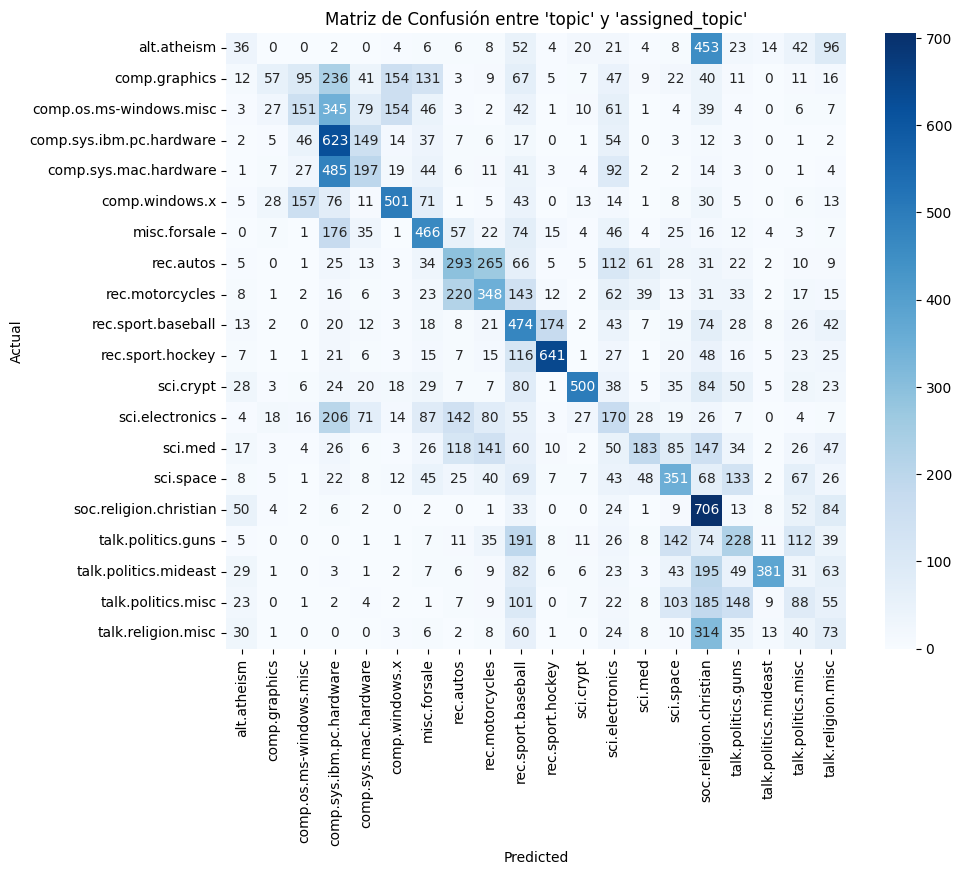

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear la tabla de contingencia como matriz de confusión
matriz_confusion = pd.crosstab(df_newsgroups['topic'], df_newsgroups['assigned_topic'], rownames=['Actual'], colnames=['Predicted'])

# Plotear la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Matriz de Confusión entre 'topic' y 'assigned_topic'")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


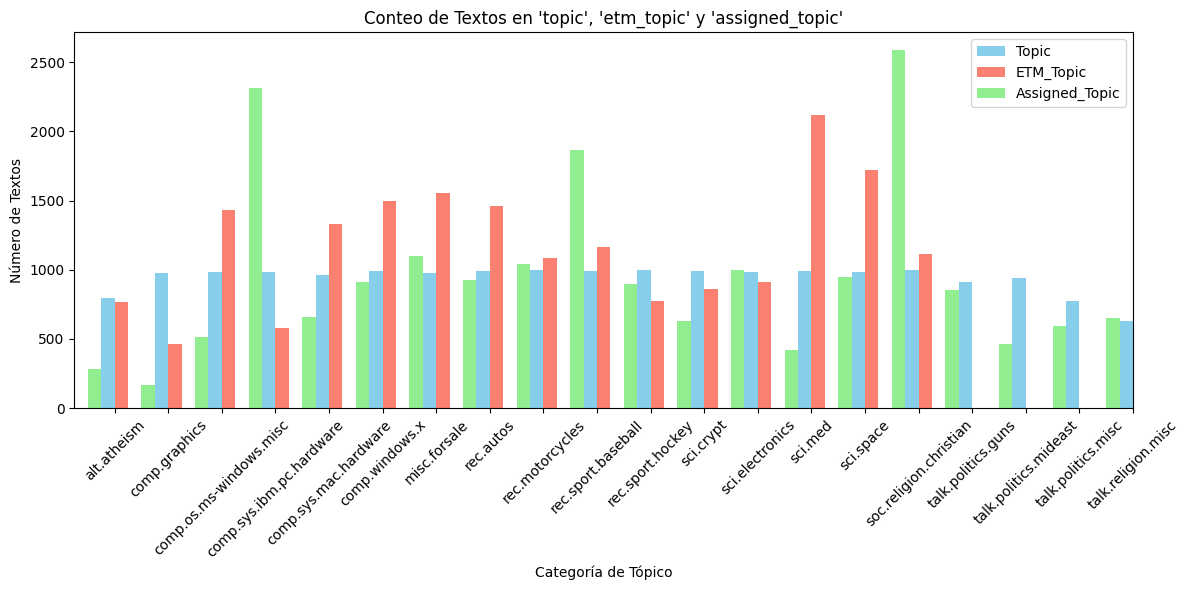

In [ ]:
import matplotlib.pyplot as plt

# Contar la cantidad de textos en cada categoría de 'topic', 'etm_topic' y 'assigned_topic'
topic_counts = df_newsgroups['topic'].value_counts().sort_index()
etm_topic_counts = df_newsgroups['etm_topic'].value_counts().sort_index()
assigned_topic_counts = df_newsgroups['assigned_topic'].value_counts().sort_index()

# Crear un gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))

# Plotear los conteos de 'topic', 'etm_topic' y 'assigned_topic'
topic_counts.plot(kind='bar', color='skyblue', ax=ax, width=0.25, position=1, label='Topic')
etm_topic_counts.plot(kind='bar', color='salmon', ax=ax, width=0.25, position=0, label='ETM_Topic')
assigned_topic_counts.plot(kind='bar', color='lightgreen', ax=ax, width=0.25, position=2, label='Assigned_Topic')

# Configurar etiquetas y título
plt.title("Conteo de Textos en 'topic', 'etm_topic' y 'assigned_topic'")
plt.xlabel("Categoría de Tópico")
plt.ylabel("Número de Textos")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [ ]:
# Contar coincidencias exactas entre 'topic' y 'assigned_topic'
coincidencias = (df_newsgroups['topic'] == df_newsgroups['assigned_topic']).sum()

# Calcular la accuracy dividiendo las coincidencias por el total de documentos
accuracy = coincidencias / len(df_newsgroups)

# Mostrar el resultado
print(f"La accuracy es: {accuracy:.4f}")


La accuracy es: 0.3431


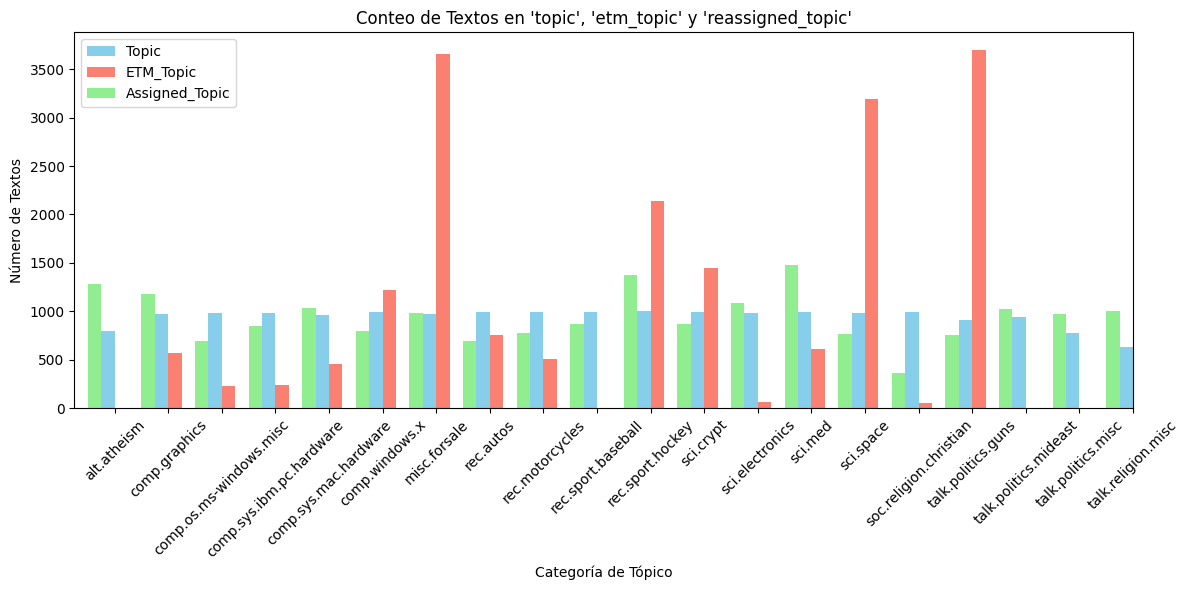

In [ ]:
import matplotlib.pyplot as plt

# Contar la cantidad de textos en cada categoría de 'topic', 'etm_topic' y 'assigned_topic'
topic_counts = df_newsgroups['topic'].value_counts().sort_index()
etm_topic_counts = df_newsgroups['etm_topic'].value_counts().sort_index()
assigned_topic_counts = df_newsgroups['reassigned_topic'].value_counts().sort_index()

# Crear un gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))

# Plotear los conteos de 'topic', 'etm_topic' y 'assigned_topic'
topic_counts.plot(kind='bar', color='skyblue', ax=ax, width=0.25, position=1, label='Topic')
etm_topic_counts.plot(kind='bar', color='salmon', ax=ax, width=0.25, position=0, label='ETM_Topic')
assigned_topic_counts.plot(kind='bar', color='lightgreen', ax=ax, width=0.25, position=2, label='Assigned_Topic')

# Configurar etiquetas y título
plt.title("Conteo de Textos en 'topic', 'etm_topic' y 'reassigned_topic'")
plt.xlabel("Categoría de Tópico")
plt.ylabel("Número de Textos")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim

# Preprocess text into tokens for coherence calculation
df_newsgroups['tokens'] = df_newsgroups['text'].apply(lambda x: gensim.utils.simple_preprocess(x))

# Group tokens by the assigned ETM topic, and flatten each group to get a single list of words per topic
topic_words = df_newsgroups.groupby('assigned_topic')['tokens'].apply(lambda docs: [word for tokens in docs for word in tokens]).tolist()

# Create a Gensim dictionary from all tokens
dictionary = Dictionary(df_newsgroups['tokens'])

# Compute coherence score using c_v (you can change this to u_mass, c_uci, or c_npmi if preferred)
coherence_model = CoherenceModel(topics=topic_words, texts=df_newsgroups['tokens'].tolist(),
                                 dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

print(f"Coherence score for ETM topics: {coherence_score:.4f}")


Coherence score for ETM topics: 0.3541


In [ ]:
# Contar coincidencias exactas entre 'topic' y 'assigned_topic'
coincidencias = (df_newsgroups['topic'] == df_newsgroups['reassigned_topic']).sum()

# Calcular la accuracy dividiendo las coincidencias por el total de documentos
accuracy = coincidencias / len(df_newsgroups)

# Mostrar el resultado
print(f"La accuracy es: {accuracy:.4f}")


La accuracy es: 0.1627
